<a href="https://colab.research.google.com/github/dibyanshu2305/Deep_learning_course_notebooks/blob/main/U_Net_Pytorch_moodle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **U-Net on LiTS DATASET-**

## Prerequisites-

In [ ]:
import tensorflow as tf
#tf.test.gpu_device_name()
device_name = tf.test.gpu_device_name()
 if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
 print('Found GPU at: {}'.format(device_name))

**Importing the libraries-**

In [ ]:
import torch
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os

#Loading the data-

## Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Google drive path of the dataset
Here we are using LiTS dataset sheets.

First add the data directory into your drive with this link: \
https://drive.google.com/drive/folders/1-4i1gYvNx2qhoVGOg1-Rqc360lhgprZU?usp=sharing \
**Note: Use only IITB account for this.**


Now change the path of the dataset :
\
Image_Path = "/content/drive/MyDrive/Liver Tumor Dataset Sheet/Image/" \
Seg_Path = "/content/drive/MyDrive/Liver Tumor Dataset Sheet/mask/"

In [ ]:
Image_names = os.listdir("/content/drive/MyDrive/Liver Tumor Dataset Sheet/Image/")

In [ ]:
#len(Image_names)

In [ ]:
#Image_names

## Loading the data from google drive folder

In [ ]:
Data=[]
k=0
resize = transforms.Compose([transforms.Resize((128,128))])
while k<2000:
  i = Image_names[k]
  img = torchvision.io.read_image("/content/drive/MyDrive/Liver Tumor Dataset Sheet/Image/"+i)
  img = resize(img / 255)
  seg = torchvision.io.read_image("/content/drive/MyDrive/Liver Tumor Dataset Sheet/mask/seg_"+i)
  seg = resize(seg / 255)
  Data.append([img,seg])
  k += 1

In [ ]:
len(Data)

In [ ]:
Data[1][0].shape

## **Train-Test Split**

In [ ]:
trainset, testset = torch.utils.data.random_split(Data, [int(0.8 * len(Data)), int(0.2 * len(Data))])

In [ ]:
print(len(trainset))
print(len(testset))

In [ ]:
trainset[1]

In [ ]:
#shape of the image tensor
img, label = trainset[0]
img_shape = img.shape
img_shape

In [ ]:
print("Max & Min Pixel Values:", "Max:", torch.max(img), "Min:", torch.min(img))
print("Pixel Values for all Channels:\n", img[:, :, :])

##**Splitting the data into test, train and validation dataset-**
Train Data Size = 1280\
Test Data Size = 400\
Validation Data Size = 320

In [ ]:
trainset, valset = torch.utils.data.random_split(trainset, [int(0.8 * len(trainset)), int(0.2 * len(trainset))])

**Shuffling and creating batches of data-**

In [ ]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True,num_workers=2)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False,num_workers=2)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False,num_workers=2)

In [ ]:
print("Training dataset size: ", len(trainset))
print("Validation dataset size: ", len(valset))
print("Testing dataset size: ", len(testset))

In [ ]:
print("No. of batches in Training dataset : ", len(train_dataloader))
print("No. of batches in Validation dataset : ", len(val_dataloader))
print("No. of batches in Testing dataset : ", len(test_dataloader))

**Visualising the data-**

In [ ]:
img, label = trainset[0]
img = img.reshape(128,128)
plt.imshow(img)

In [ ]:
label = label.reshape(128,128)
plt.imshow(label)

In [ ]:
for images, _ in train_dataloader:
    print('Shape of an Image (Batch Size, channels, Pixels):', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0))) # we need permute here because matplotlib wants to have the channels as the last dimension
    break

In [ ]:
def TabularFormat(epochs,train_cost,train_acc,eval_cost,eval_acc):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)
  return pd.DataFrame(list(zip(ep,train_cost,train_acc,eval_cost,eval_acc)),columns = ['Epoch Value','Training Loss','Training Dice Score','Validation loss','Validation Dice Score'])

In [ ]:
def GraphicalFormat(epochs,train_cost,train_acc,eval_cost,eval_acc):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)

  plt.figure(figsize =(12,7))
  plt.plot(ep,eval_cost,label = "Evaluation Loss")
  plt.plot(ep,train_cost,label = "Training Loss")
  plt.ylabel("Loss",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12,loc = "best")
  plt.title("Graph between value of Trainig and Validation Loss V/s Epochs",fontsize = 15)
  plt.show()
  print("\n\n__________________________________________________\n\n")
  plt.figure(figsize =(12,7))
  plt.plot(ep,train_acc,label = "Training Dice Score")
  plt.plot(ep,eval_acc,label = "Val Dice Score")
  plt.ylabel("Dice Score",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12,loc = "best")
  plt.title("Graph between Trainig and Validation Dice Score V/s Epochs",fontsize = 15)
  plt.show()

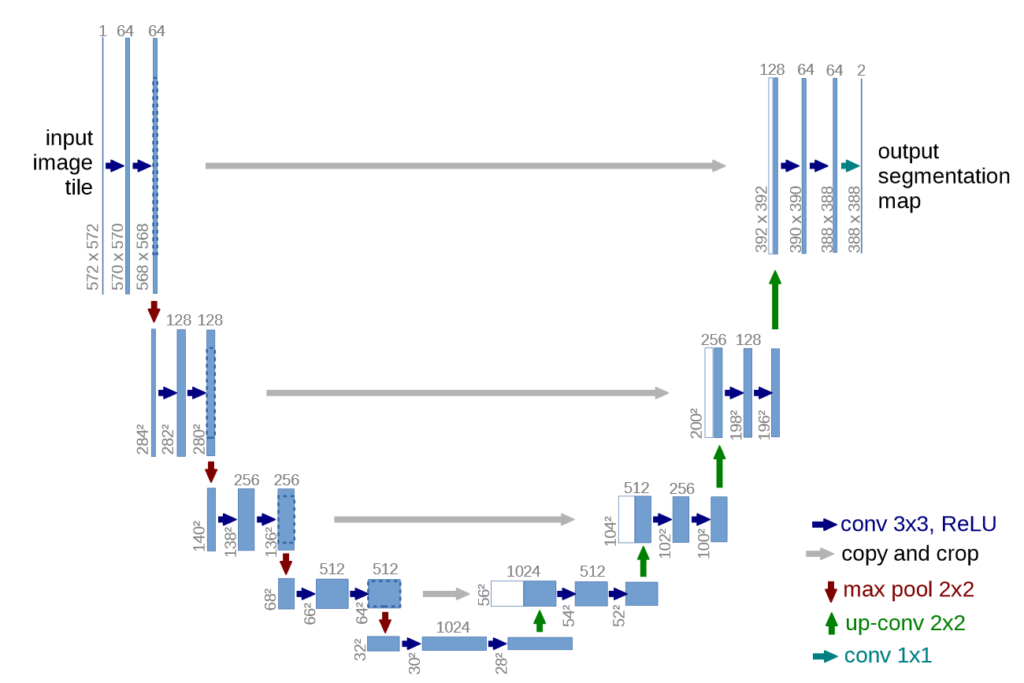

##Convolutional Block
The entire UNET architecture uses two 3×3 convolutional layers, each followed by a ReLU activation.\
Here we create a simple class named conv_block:-


In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    return x

##Encoder Block
The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3×3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.\
\
In the encoder_block, we have used padding to make sure that the shape (height and width) of the output feature maps remain the same as the input feature maps.\
The encoder_block consists of a conv_block followed by a 2×2 max pooling. The number of filters is doubled and the height and width are reduced half after every block.\
The encoder_block return two output:
1. x: It is the output of the conv_block and acts as the input of the pooling layer and as the skip connection feature map for the decoder block.
2. p: It is the output of the pooling layer.


In [ ]:
class encoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv = conv_block(in_c, out_c)
    self.pool = nn.MaxPool2d((2, 2))
  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)
    return x, p

##Decoder Block
From the original paper
Every step in the expansive path consists of an upsampling of the feature map followed by a 2×2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3×3 convolutions, each followed by a ReLU

In [ ]:
class decoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
    self.conv = conv_block(out_c+out_c, out_c)
  def forward(self, inputs, skip):
    x = self.up(inputs)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x

#**UNET Architecture**





In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    """ Encoder """
    self.e1 = encoder_block(1,32)#(1, 64)
    self.e2 = encoder_block(32,64)#(64, 128)
    self.e3 = encoder_block(64,128)#(128, 256)
    self.e4 = encoder_block(128,256)#(256, 512)
    """ Bottleneck """
    self.b = conv_block(256,512)#(512, 1024)
    """ Decoder """
    self.d1 = decoder_block(512,256)#(1024, 512)
    self.d2 = decoder_block(256,128)#(512, 256)
    self.d3 = decoder_block(128,64)#(256, 128)
    self.d4 = decoder_block(64,32)#(128, 64)
    self.relu = nn.ReLU()
    """ Classifier """
    self.outputs = nn.Conv2d(32, 1, kernel_size=1, padding=0)#(64, 1, kernel_size=1, padding=0)
  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    """ Bottleneck """
    b = self.b(p4)
    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)
    """ Classifier """
    outputs = self.outputs(d4)
    #outputs = self.relu(outputs)
    return outputs



def Dice_score(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

# def init_model(net):
#     if isinstance(net, nn.Conv2d) or isinstance(net, nn.ConvTranspose2d):
#         nn.init.kaiming_normal_(net.weight.data, 0.25)
#         nn.init.constant_(net.bias.data, 0)



#Initialising the model2
model2 = UNet()
print("The overall model2 is - \n")
print(model2)
dash = "________________________________________________________________________\n\n"
print(dash)
# model.apply(init_model)




CE = nn.CrossEntropyLoss()
MSE = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=0.001)

# Print model2's state_dict
print("Model2's state_dict:")
for param_tensor in model2.state_dict():
    print(param_tensor, "\t", model2.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

if (torch.cuda.is_available()):
    model2.cuda()

def count_parameters(model2):
    return sum(p.numel() for p in model2.parameters() if p.requires_grad)

print(f'The model2 has {count_parameters(model2):,} trainable parameters')

## **Dice Score**

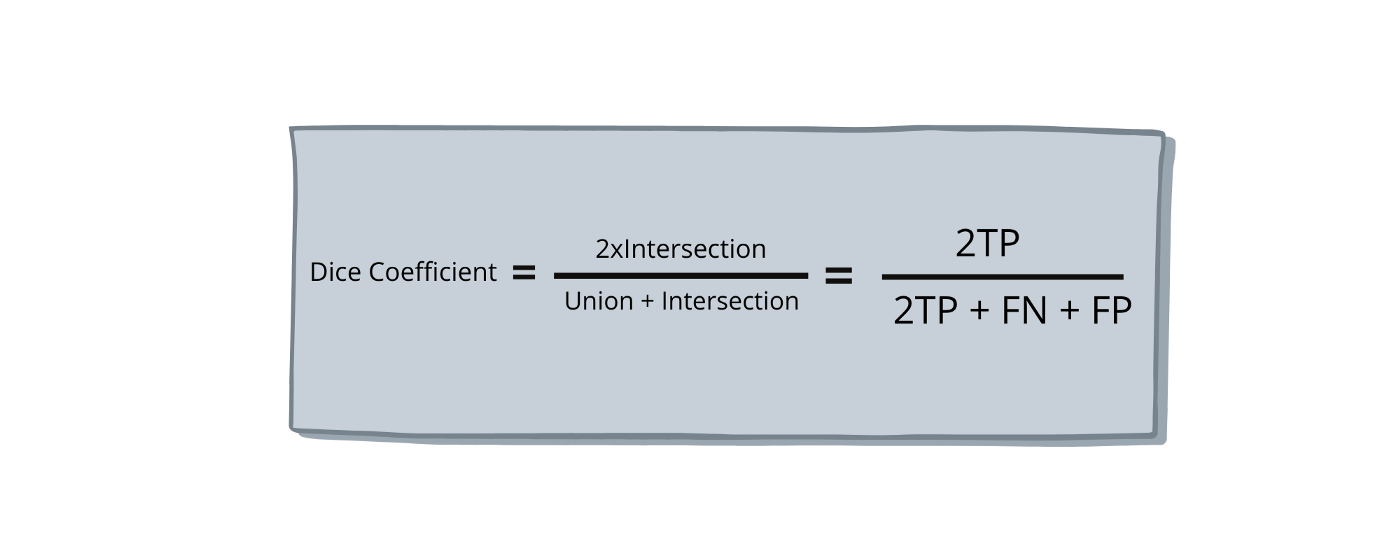

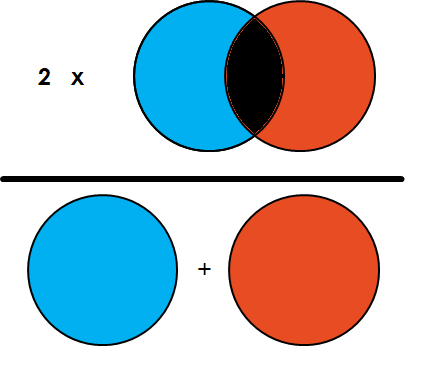

https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

## **Training**

In [ ]:
no_epochs = 100
train_loss = list()
val_loss = list()
train_Dice= list()
val_Dice = list()
best_val_loss = 1
total_train_Dice = 0
total_val_Dice = 0
total_val = 0

for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0
    total_train = 0
    Dice = 0
    model2.train()
    total_p = 0
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()
        optimizer.zero_grad()
        
        pred = model2(image.float())
        #print(image.min())
        #print(pred.min())
        #print(label.min())

        loss = MSE(pred, label.float())
        #print(loss)
        total_train_loss += loss.item()
        #ADDED HERE
        
        Dice = Dice_score(pred, label)
        total_train_Dice += Dice.item()     

        loss.backward()
        optimizer.step()
        # print(itr+1, "Train Batch complete")
    total_train_Dice = total_train_Dice / (itr+1)
    train_Dice.append(total_train_Dice)
    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)
    

    # validation
    model2.eval()
    total_val = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model2(image.float())

        loss = MSE(pred, label.float())
        total_val_loss += loss.item()

        Dice = Dice_score(pred, label)
        total_val_Dice += Dice.item()     


    total_val_Dice = total_val_Dice / (itr+1)
    val_Dice.append(total_val_Dice)
    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f},Train Dice: {:.8f}, Val Loss: {:.8f}, Val DIce: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_train_Dice, total_val_loss, total_val_Dice))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model2 state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model2.state_dict(), "model2.dth")

In [ ]:
import pandas as pd
pd = TabularFormat(no_epochs,train_loss,train_Dice,val_loss,val_Dice)
pd

In [ ]:
GraphicalFormat(no_epochs,train_loss,train_Dice,val_loss,val_Dice)

# **Evaluating the model2-**

In [ ]:
total_val_loss = 0
# validation

model2.load_state_dict(torch.load('model2.dth'))
model2.eval()
total_val = 0
Dice = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model2(image.float())
    loss = MSE(pred, label)
    total_val_loss += loss.item()

    Dice = Dice_score(pred, label)
    total_val_Dice += Dice.item()


total_val_Dice = total_val_Dice / (itr+1)
val_Dice.append(total_val_Dice)
total_val_loss = total_val_loss / (itr + 1)
val_loss.append(total_val_loss)
print('\n Val Loss: {:.8f}, Val Dice: {:.8f}'.format( total_val_loss, total_val_Dice))

## Example 1

In [ ]:
img, seg = testset[11]

In [ ]:
imge = img.reshape(128,128)
plt.imshow(imge)

In [ ]:
segm = seg.reshape(128,128)
plt.imshow(segm)

In [ ]:
model2.load_state_dict(torch.load('model2.dth'))
model2.eval()
img = img.view(1,1,128,128)
img = img.cuda()
pred = model2(img.float())

In [ ]:
pred = pred.cpu()
pred =pred.detach().numpy()
predt = pred.reshape(128,128)
plt.imshow(predt)

## Example 1

In [ ]:
img, seg = testset[50]

In [ ]:
imge = img.reshape(128,128)
plt.imshow(imge)

In [ ]:
segm = seg.reshape(128,128)
plt.imshow(segm)

In [ ]:
model2.load_state_dict(torch.load('model2.dth'))
model2.eval()
img = img.view(1,1,128,128)
img = img.cuda()
pred = model2(img.float())

In [ ]:
pred = pred.cpu()
pred =pred.detach().numpy()
predt = pred.reshape(128,128)
plt.imshow(predt)

##UNET Architecture
Decrease No. of Features:


In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    """ Encoder """
    self.e1 = encoder_block(1,16)#(1, 64)
    self.e2 = encoder_block(16,32)#(64, 128)
    self.e3 = encoder_block(32,64)#(128, 256)
    self.e4 = encoder_block(64,128)#(256, 512)
    """ Bottleneck """
    self.b = conv_block(128,256)#(512, 1024)
    """ Decoder """
    self.d1 = decoder_block(256,128)#(1024, 512)
    self.d2 = decoder_block(128,64)#(512, 256)
    self.d3 = decoder_block(64,32)#(256, 128)
    self.d4 = decoder_block(32,16)#(128, 64)
    self.relu = nn.ReLU()
    """ Classifier """
    self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)#(64, 1, kernel_size=1, padding=0)
  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    """ Bottleneck """
    b = self.b(p4)
    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)
    """ Classifier """
    outputs = self.outputs(d4)
    #outputs = self.relu(outputs)
    return outputs




#Initialising the model
model = UNet()
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


#criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9, weight_decay=0.001)

def Dice_score(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

# def init_model(net):
#     if isinstance(net, nn.Conv2d) or isinstance(net, nn.ConvTranspose2d):
#         nn.init.kaiming_normal_(net.weight.data, 0.25)
#         nn.init.constant_(net.bias.data, 0)
      
# model.apply(init_model)
criterion = nn.CrossEntropyLoss()
MSE = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

if (torch.cuda.is_available()):
    model.cuda()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
no_epochs = 100
train_loss = list()
val_loss = list()
train_Dice= list()
val_Dice = list()
best_val_loss = 1
total_train_Dice = 0
total_val_Dice = 0
total_val = 0

for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0
    total_train = 0
    Dice = 0
    model.train()
    total_p = 0
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()
        optimizer.zero_grad()
        
        pred = model(image.float())
        #print(image.min())
        #print(pred.min())
        #print(label.min())

        loss = MSE(pred, label.float())
        #print(loss)
        total_train_loss += loss.item()
        #ADDED HERE
        
        Dice = Dice_score(pred, label)
        total_train_Dice += Dice.item()     

        loss.backward()
        optimizer.step()
        # print(itr+1, "Train Batch complete")
    total_train_Dice = total_train_Dice / (itr+1)
    train_Dice.append(total_train_Dice)
    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)
    

    # validation
    model.eval()
    total_val = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image.float())

        loss = MSE(pred, label.float())
        total_val_loss += loss.item()

        Dice = Dice_score(pred, label)
        total_val_Dice += Dice.item()     


    total_val_Dice = total_val_Dice / (itr+1)
    val_Dice.append(total_val_Dice)
    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f},Train Dice: {:.8f}, Val Loss: {:.8f}, Val DIce: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_train_Dice, total_val_loss, total_val_Dice))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

In [ ]:
import pandas as pd
pd = TabularFormat(no_epochs,train_loss,train_Dice,val_loss,val_Dice)
pd

In [ ]:
GraphicalFormat(no_epochs,train_loss,train_Dice,val_loss,val_Dice)

# **Evaluating the model-**

In [ ]:
total_val_loss = 0
# validation

model.load_state_dict(torch.load('model.dth'))
model.eval()
total_val = 0
Dice = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image.float())
    loss = MSE(pred, label)
    total_val_loss += loss.item()

    Dice = Dice_score(pred, label)
    total_val_Dice += Dice.item()


total_val_Dice = total_val_Dice / (itr+1)
val_Dice.append(total_val_Dice)
total_val_loss = total_val_loss / (itr + 1)
val_loss.append(total_val_loss)
print('\n Val Loss: {:.8f}, Val Dice: {:.8f}'.format( total_val_loss, total_val_Dice))

## Example 1

In [ ]:
img, seg = testset[11]

In [ ]:
imge = img.reshape(128,128)
plt.imshow(imge)

In [ ]:
segm = seg.reshape(128,128)
plt.imshow(segm)

In [ ]:
model.load_state_dict(torch.load('model.dth'))
model.eval()
img = img.view(1,1,128,128)
img = img.cuda()
pred = model(img.float())

In [ ]:
pred = pred.cpu()
pred =pred.detach().numpy()
predt = pred.reshape(128,128)
plt.imshow(predt)

## Example 2

In [ ]:
img, seg = testset[51]

In [ ]:
imge = img.reshape(128,128)
plt.imshow(imge)

In [ ]:
segm = seg.reshape(128,128)
plt.imshow(segm)

In [ ]:
model.load_state_dict(torch.load('model.dth'))
model.eval()
img = img.view(1,1,128,128)
img = img.cuda()
pred = model(img.float())

In [ ]:
pred = pred.cpu()
pred =pred.detach().numpy()
predt = pred.reshape(128,128)
plt.imshow(predt)

##UNET Architecture
Again decrease the no. of features




In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    """ Encoder """
    self.e1 = encoder_block(1,8)#(1, 64)
    self.e2 = encoder_block(8,16)#(64, 128)
    self.e3 = encoder_block(16,32)#(128, 256)
    self.e4 = encoder_block(32,64)#(256, 512)
    """ Bottleneck """
    self.b = conv_block(64,128)#(512, 1024)
    """ Decoder """
    self.d1 = decoder_block(128,64)#(1024, 512)
    self.d2 = decoder_block(64,32)#(512, 256)
    self.d3 = decoder_block(32,16)#(256, 128)
    self.d4 = decoder_block(16,8)#(128, 64)
    self.relu = nn.ReLU()
    """ Classifier """
    self.outputs = nn.Conv2d(8, 1, kernel_size=1, padding=0)#(64, 1, kernel_size=1, padding=0)
  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    """ Bottleneck """
    b = self.b(p4)
    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)
    """ Classifier """
    outputs = self.outputs(d4)
    #outputs = self.relu(outputs)
    return outputs




#Initialising the model
model = UNet()
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


#criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9, weight_decay=0.001)

def Dice_score(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

# def init_model(net):
#     if isinstance(net, nn.Conv2d) or isinstance(net, nn.ConvTranspose2d):
#         nn.init.kaiming_normal_(net.weight.data, 0.25)
#         nn.init.constant_(net.bias.data, 0)
      
# model.apply(init_model)
criterion = nn.CrossEntropyLoss()
MSE = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

if (torch.cuda.is_available()):
    model.cuda()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
no_epochs = 100
train_loss = list()
val_loss = list()
train_Dice= list()
val_Dice = list()
best_val_loss = 1
total_train_Dice = 0
total_val_Dice = 0
total_val = 0

for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0
    total_train = 0
    Dice = 0
    model.train()
    total_p = 0
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()
        optimizer.zero_grad()
        
        pred = model(image.float())
        #print(image.min())
        #print(pred.min())
        #print(label.min())

        loss = MSE(pred, label.float())
        #print(loss)
        total_train_loss += loss.item()
        #ADDED HERE
        
        Dice = Dice_score(pred, label)
        total_train_Dice += Dice.item()     

        loss.backward()
        optimizer.step()
        # print(itr+1, "Train Batch complete")
    total_train_Dice = total_train_Dice / (itr+1)
    train_Dice.append(total_train_Dice)
    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)
    

    # validation
    model.eval()
    total_val = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image.float())

        loss = MSE(pred, label.float())
        total_val_loss += loss.item()

        Dice = Dice_score(pred, label)
        total_val_Dice += Dice.item()     


    total_val_Dice = total_val_Dice / (itr+1)
    val_Dice.append(total_val_Dice)
    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f},Train Dice: {:.8f}, Val Loss: {:.8f}, Val DIce: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_train_Dice, total_val_loss, total_val_Dice))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

In [ ]:
import pandas as pd
pd = TabularFormat(no_epochs,train_loss,train_Dice,val_loss,val_Dice)
pd

In [ ]:
GraphicalFormat(no_epochs,train_loss,train_Dice,val_loss,val_Dice)

# **Evaluating the model-**

In [ ]:
total_val_loss = 0
# validation

model.load_state_dict(torch.load('model.dth'))
model.eval()
total_val = 0
Dice = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image.float())
    loss = MSE(pred, label)
    total_val_loss += loss.item()

    Dice = Dice_score(pred, label)
    total_val_Dice += Dice.item()


total_val_Dice = total_val_Dice / (itr+1)
val_Dice.append(total_val_Dice)
total_val_loss = total_val_loss / (itr + 1)
val_loss.append(total_val_loss)
print('\n Val Loss: {:.8f}, Val Dice: {:.8f}'.format( total_val_loss, total_val_Dice))

## Example 1

In [ ]:
img, seg = testset[11]

In [ ]:
imge = img.reshape(128,128)
plt.imshow(imge)

In [ ]:
segm = seg.reshape(128,128)
plt.imshow(segm)

In [ ]:
model.load_state_dict(torch.load('model.dth'))
model.eval()
img = img.view(1,1,128,128)
img = img.cuda()
pred = model(img.float())

In [ ]:
pred = pred.cpu()
pred =pred.detach().numpy()
predt = pred.reshape(128,128)
plt.imshow(predt)

## Example 1

In [ ]:
img, seg = testset[50]

In [ ]:
imge = img.reshape(128,128)
plt.imshow(imge)

In [ ]:
segm = seg.reshape(128,128)
plt.imshow(segm)

In [ ]:
model.load_state_dict(torch.load('model.dth'))
model.eval()
img = img.view(1,1,128,128)
img = img.cuda()
pred = model(img.float())

In [ ]:
pred = pred.cpu()
pred =pred.detach().numpy()
predt = pred.reshape(128,128)
plt.imshow(predt)